In [17]:
import earthaccess
from utils.location import get_location

lon, lat = get_location()

loc_range = 7

lat_min = lat - loc_range
lat_max = lat + loc_range
lon_min = lon - loc_range
lon_max = lon + loc_range

auth = earthaccess.login()
results = earthaccess.search_data(
    short_name="MCD12Q1",
    temporal=("2024-01-01", "2025-01-02"),
    bounding_box=(lon_min, lat_min, lon_max, lat_max)
)

In [18]:
print(len(results))
print(results[0].data_links()[0])

4
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MCD12Q1.061/MCD12Q1.A2024001.h19v03.061.2025205183907/MCD12Q1.A2024001.h19v03.061.2025205183907.hdf


In [19]:
files = earthaccess.download(results[:2], '../data/raw')

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
import rioxarray as rxr
import xarray as xr
from typing import cast

datasets = [ rxr.open_rasterio(f'../data/raw/{file.name}', masked=True, chunks={'x': 1024, 'y': 1024})
                for file in files]

datasets[0]

<xarray.Dataset> Size: 300MB
Dimensions:              (band: 1, x: 2400, y: 2400)
Coordinates:
  * band                 (band) int64 8B 1
  * x                    (x) float64 19kB 1.112e+06 1.113e+06 ... 2.224e+06
  * y                    (y) float64 19kB 6.671e+06 6.671e+06 ... 5.56e+06
    spatial_ref          int64 8B 0
Data variables: (12/13)
    LC_Type1             (band, y, x) float32 23MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    LC_Prop2             (band, y, x) float32 23MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    LC_Prop3             (band, y, x) float32 23MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    QC                   (band, y, x) float32 23MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    LW                   (band, y, x) float32 23MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    LC_Type2             (band, y, x) float32 23MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    ...                   ...
    LC_Type4             (band, y, x) float32 23MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    LC_Type5             (band, y, x) float32 23MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    LC_Prop1_Assessment  (band, y, x) float32 23MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    LC_Prop2_Assessment  (band, y, x) float32 23MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    LC_Prop3_Assessment  (band, y, x) float32 23MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    LC_Prop1             (band, y, x) float32 23MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes: (12/64)
    ALGORITHMPACKAGEACCEPTANCEDATE:     1998-01-01
    ALGORITHMPACKAGEMATURITYCODE:       LAUNCH
    ALGORITHMPACKAGENAME:               MOD12Q1
    ALGORITHMPACKAGEVERSION:            V2.0
    ASSOCIATEDINSTRUMENTSHORTNAME.1:    MODIS
    ASSOCIATEDINSTRUMENTSHORTNAME.2:    MODIS
    ...                                 ...
    SOUTHBOUNDINGCOORDINATE:            50.0
    SPSOPARAMETERS:                     2669
    TileID:                             51019003
    VERSIONID:                          61
    VERTICALTILENUMBER:                 3
    WESTBOUNDINGCOORDINATE:             15.557238

In [21]:
import numpy as np


if not all(isinstance(x, xr.Dataset) for x in datasets):
    raise SystemExit("Datasets are not in correct format")

ds_latlon = [ ds.rio.reproject("EPSG:4326", dtype="float32", nodata=np.nan, resolution=0.01,
                              transform=None, shape=None, 
                              resampling="nearest", 
                              chunks={'x': 512, 'y': 512}) for ds in datasets ]

ds = xr.concat(ds_latlon, dim="time", join='outer')

years = [int(f.name[9:13]) for f in files]
ds = ds.assign_coords(time=("time", years))


In [22]:
land_types_ds = ds.where(
        (ds["y"] >= lat_min)
        & (ds["y"] <= lat_max)
        & (ds["x"] >= lon_min)
        & (ds["x"] <= lon_max),
        drop=True,
    )

land_types_df = land_types_ds[["LC_Type1", "x", "y", "time"]].to_dataframe().reset_index()

land_types_df = land_types_df.rename(columns={"y": "lat", "x": "lon", "LC_Type1": "land_cover_type"})
land_types_df = land_types_df.dropna()
types = datasets[0]['LC_Type1'].attrs
keys = list(types.keys())
values = list(types.values())

land_types_df['land_cover_type_name'] = [keys[values.index(lc_type)] for lc_type in land_types_df['land_cover_type']]
land_types_df

,time,band,lat,lon,land_cover_type,spatial_ref,land_cover_type_name
667955,2024,1,50.005,15.562238,12.0,0,Croplands
667956,2024,1,50.005,15.572238,12.0,0,Croplands
667957,2024,1,50.005,15.582238,12.0,0,Croplands
667958,2024,1,50.005,15.592238,12.0,0,Croplands
667959,2024,1,50.005,15.602238,12.0,0,Croplands
...,...,...,...,...,...,...,...
2626550,2024,1,49.995,15.515000,5.0,0,Mixed Forests
2626551,2024,1,49.995,15.525000,9.0,0,Savannas
2626552,2024,1,49.995,15.535000,9.0,0,Savannas
2626553,2024,1,49.995,15.545000,12.0,0,Croplands


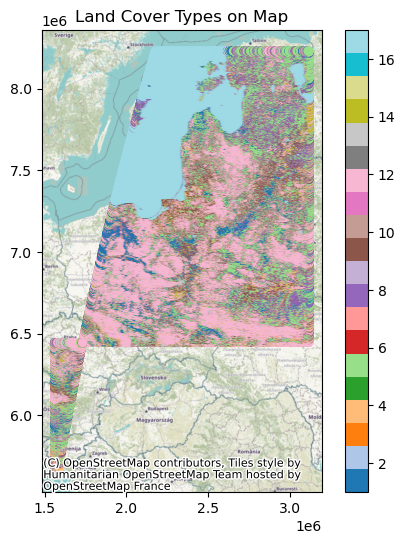

In [23]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

gdf = gpd.GeoDataFrame(land_types_df, geometry=gpd.points_from_xy(land_types_df.lon, land_types_df.lat), crs='EPSG:4326')
gdf = gdf.to_crs(epsg=3857)

ax = gdf.plot(column='land_cover_type', cmap='tab20', markersize=30, legend=True, figsize=(6, 6))
ctx.add_basemap(ax)
plt.title("Land Cover Types on Map")
plt.show()